In [1]:
import FinanceDataReader as fdr
import talib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import optuna

c:\Users\User\AppData\Local\anaconda3\envs\jmc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 다른 종목 적용 (MS)

UPS
                  Open        High         Low      Close   Volume
Date                                                              
2014-01-02  104.629997  104.910004  102.820000  74.292168  2799700
2014-01-03  103.480003  103.940002  103.050003  74.126801  3719600
2014-01-06  103.529999  103.669998  101.230003  73.163277  3884800
2014-01-07  101.839996  102.889999  101.800003  73.400543  3385700
2014-01-08  102.120003  102.279999  101.410004  73.343025  3024400


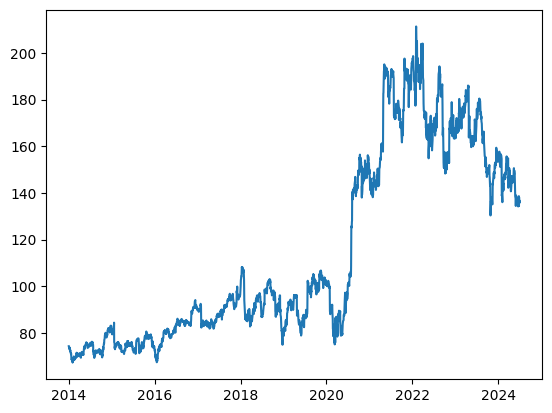

MSFT
                 Open       High        Low      Close    Volume
Date                                                            
2014-01-02  37.349998  37.400002  37.099998  31.176834  30632200
2014-01-03  37.200001  37.220001  36.599998  30.967089  31134800
2014-01-06  36.849998  36.889999  36.110001  30.312666  43603700
2014-01-07  36.330002  36.490002  36.209999  30.547590  35802800
2014-01-08  36.000000  36.139999  35.580002  30.002245  59971700


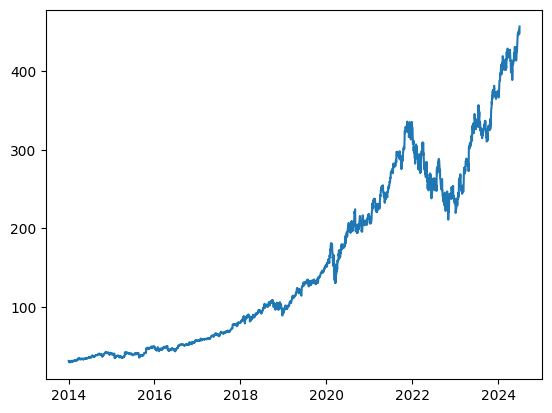

In [2]:
# 종목 및 구간 설정
tickers = ['UPS', 'MSFT']
start_date = '2014-01-01'
end_date = '2024-07-02'

for ticker_symbol in tickers:
    print(ticker_symbol)
    data = fdr.DataReader(ticker_symbol, start=start_date, end=end_date)

    # 컬럼 선택
    selected_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
    selected_data = data[selected_columns]

    # 수정 종가 컬럼 종가로 이름 변경
    selected_data = selected_data.rename(columns={'Adj Close': 'Close'})

    # 동적으로 변수 생성 및 할당
    globals()[ticker_symbol] = selected_data

    print(globals()[ticker_symbol].head())

    plt.plot(globals()[ticker_symbol].index, globals()[ticker_symbol]["Close"])
    plt.show()

# 1. Microsoft

In [3]:
MSFT['label'] = MSFT['Close'].shift(-1)
MSFT['label'] = MSFT.apply(lambda row: 'up' if row['label'] > row['Close'] else 'down', axis=1)

MSFT = MSFT[:-1]
MSFT

,Open,High,Low,Close,Volume,label
Date,,,,,,
2014-01-02,37.349998,37.400002,37.099998,31.176834,30632200,down
2014-01-03,37.200001,37.220001,36.599998,30.967089,31134800,down
2014-01-06,36.849998,36.889999,36.110001,30.312666,43603700,up
2014-01-07,36.330002,36.490002,36.209999,30.547590,35802800,down
2014-01-08,36.000000,36.139999,35.580002,30.002245,59971700,down
...,...,...,...,...,...,...
2024-06-24,449.799988,452.750000,446.410004,447.670013,15913700,up
2024-06-25,448.250000,451.420013,446.750000,450.950012,16747500,up
2024-06-26,449.000000,453.600006,448.190002,452.160004,16507000,up


In [4]:
# 클래스 균형 확인
MSFT["label"].value_counts()

label
up      1406
down    1234
Name: count, dtype: int64

In [19]:
close = MSFT['Close']
volume = MSFT["Volume"]

In [20]:
df = MSFT.copy()

df.loc[:, 'cmo'] = talib.CMO(close, timeperiod=14)
df.loc[:, 'ht_dcperiod'] = talib.HT_DCPERIOD(close)
df.loc[:, 'ht_dcphase'] = talib.HT_DCPHASE(close)
sine, leadsine = talib.HT_SINE(close)
df.loc[:, 'sine'] = sine
df.loc[:, 'leadsine'] = leadsine
df.loc[:, 'ht_trendmode'] = talib.HT_TRENDMODE(close)
df.loc[:, 'ppo'] = talib.PPO(close, fastperiod=12, slowperiod=26)
df.loc[:, 'roc'] = talib.ROC(close, timeperiod=10)
df.loc[:, 'rsi'] = talib.RSI(close, timeperiod=14)
fastk, fastd = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3)
df.loc[:, 'fastk'] = fastk
df.loc[:, 'fastd'] = fastd
df.loc[:, 'trix'] = talib.TRIX(close, timeperiod=30)

In [21]:
# 특정 날짜 이전의 행 삭제
cutoff_date = pd.Timestamp('2014-06-02')
df = df[df.index >= cutoff_date]
df

,Open,High,Low,Close,Volume,label,cmo,ht_dcperiod,ht_dcphase,sine,leadsine,ht_trendmode,ppo,roc,rsi,fastk,fastd,trix
Date,,,,,,,,,,,,,,,,,,
2014-06-02,40.950001,41.090000,40.680000,34.722214,18504300,down,20.854120,14.261191,163.162396,0.289660,-0.471972,1,0.600994,2.410206,60.427060,77.084615,92.361538,0.100237
2014-06-03,40.599998,40.680000,40.250000,34.296600,18068900,up,7.287501,14.244219,158.889549,0.360167,-0.404975,1,0.681089,1.358477,53.643751,6.633629,61.239415,0.099130
2014-06-04,40.209999,40.369999,39.860001,34.322132,23209000,up,7.955021,14.210956,170.344908,0.167717,-0.578497,1,0.808962,1.612892,53.977510,3.712691,29.143645,0.098002
2014-06-05,40.590000,41.250000,40.400002,35.079742,31865200,up,25.171301,14.249004,181.277488,-0.022295,-0.722696,1,1.018003,2.131353,62.585651,99.468319,36.604880,0.097457
2014-06-06,41.480000,41.660000,41.240002,35.309566,24060500,down,29.480372,14.432255,183.410911,-0.059496,-0.747925,1,1.260562,3.441340,64.740186,100.000000,67.727004,0.097555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,449.799988,452.750000,446.410004,447.670013,15913700,up,36.621546,23.960310,138.967042,0.656493,-0.069183,1,2.004842,5.619914,68.310773,0.000000,23.960613,0.092055
2024-06-25,448.250000,451.420013,446.750000,450.950012,16747500,up,41.101105,22.922544,151.134351,0.482757,-0.277891,1,2.242677,5.394166,70.550552,68.892865,45.618382,0.098191
2024-06-26,449.000000,453.600006,448.190002,452.160004,16507000,up,42.709777,22.088746,165.975284,0.242340,-0.514668,1,2.497310,4.502175,71.354888,93.633258,54.175374,0.104430


In [22]:
# 전처리
df = df.copy()
df['label'] = df['label'].map({'up': 1, 'down': 0})
df.index = pd.to_datetime(df.index)
idx = pd.Timestamp('2023-01-01')
train_data = df[df.index < idx]
test_data = df[df.index >= idx]

# 수익률 계산을 위한 데이터프레임 준비
calcu_df = df.copy()
calcu_df = calcu_df[['Open','Close', 'label']]
calcu_df = calcu_df[calcu_df.index >= idx]
calcu_df.head(5)

,Open,Close,label
Date,,,
2023-01-03,243.080002,236.609222,0
2023-01-04,232.279999,226.259155,0
2023-01-05,227.199997,219.553375,1
2023-01-06,223.000000,222.140900,1
2023-01-09,226.449997,224.303711,1


### logistic regression

In [55]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# 모델 선언
lr = LogisticRegression(random_state=123)
# 모델 학습
lr.fit(train_x_scaled, train_y)
# train, test 추정
train_pred = lr.predict(train_x_scaled)
y_pred = lr.predict(test_x_scaled)
# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)
# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.5469
test Accuracy: 0.5134


In [56]:
# 변수 중요도 출력
feature_importance = lr.coef_[0]
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

         Feature  Importance
10         fastd    0.107094
11          trix    0.029825
5   ht_trendmode    0.010015
6            ppo   -0.008400
3           sine   -0.021332
0            cmo   -0.024848
8            rsi   -0.024848
7            roc   -0.058997
2     ht_dcphase   -0.093643
1    ht_dcperiod   -0.102074
9          fastk   -0.108972
4       leadsine   -0.139455


In [41]:
# 중요도가 양수인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > -0.09]['Feature']

# 양수 변수만을 사용한 새로운 데이터 준비
train_x_lr = train_x[positive_features]
test_x_lr = test_x[positive_features]

# 데이터 스케일링
train_x_lr = scaler.fit_transform(train_x_lr)
test_x_lr = scaler.transform(test_x_lr)

# 모델 선언 및 학습
lr_important_v = LogisticRegression(random_state=123)
lr_important_v.fit(train_x_lr, train_y)

train_pred_important_v = lr_important_v.predict(train_x_lr)
y_pred_important_v = lr_important_v.predict(test_x_lr)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

train Accuracy: 0.5381
test Accuracy: 0.5401


In [42]:
# 수익률 계산용 데이터프레임에 예측값 추가
calcu_df['lr_predict'] = y_pred
calcu_df.head(5)
calcu_df['lr_predict'].value_counts()

lr_predict
1    229
0    145
Name: count, dtype: int64

### KNN

In [43]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# 모델 선언
knn = KNeighborsClassifier()

# 모델 학습
knn.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = knn.predict(train_x_scaled)
y_pred = knn.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.6833
test Accuracy: 0.5214


In [45]:
# GridSearchCV를 사용하여 최적의 k 값 찾기 (전체 변수)
param_grid = {'n_neighbors': np.arange(1, 75)}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x_scaled, train_y)

# 최적의 k 값
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 55


In [46]:
# 파라미터 최적화 후 KNN 모델 생성
knn_bp = KNeighborsClassifier(n_neighbors = 55)

knn_bp.fit(train_x_scaled, train_y)

train_pred_bp = knn_bp.predict(train_x_scaled)
y_pred_bp = knn_bp.predict(test_x_scaled)

train_accuracy_bp = accuracy_score(train_y, train_pred_bp)
accuracy_bp = accuracy_score(test_y, y_pred_bp)

print(f"train Accuracy: {train_accuracy_bp:.4f}")
print(f"test Accuracy: {accuracy_bp:.4f}")

train Accuracy: 0.5428
test Accuracy: 0.5080


In [49]:
# 수익률 계산용 데이터프레임에 랜덤포레스트 예측값 추가
calcu_df['knn_predict'] = y_pred_bp
calcu_df.head(5)
calcu_df['knn_predict'].value_counts()

knn_predict
1    263
0    111
Name: count, dtype: int64

### naive baise

In [52]:
## 변수 집합
select_nb = ['ht_dcperiod', 'ht_dcphase', 'ht_trendmode', 'sine', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select_nb]
train_y = train_data['label']
test_x = test_data[select_nb]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_nb = scaler.fit_transform(train_x)
test_x_nb = scaler.transform(test_x)

# 모델 선언
nb = GaussianNB()

# 모델 학습
nb.fit(train_x_nb, train_y)

# train, test 추정
train_pred = nb.predict(train_x_nb)
y_pred = nb.predict(test_x_nb)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.5307
test Accuracy: 0.5294


In [53]:
# 수익률 계산용 데이터프레임에 랜덤포레스트 예측값 추가
calcu_df['nb_predict'] = y_pred
calcu_df.head(5)
calcu_df['nb_predict'].value_counts()

nb_predict
0    201
1    173
Name: count, dtype: int64

### random forest

In [57]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# 모델 선언
rf = RandomForestClassifier(random_state=123)

# 모델 학습
rf.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = rf.predict(train_x_scaled)
y_pred = rf.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 1.0000
test Accuracy: 0.5134


         Feature  Importance
1    ht_dcperiod    0.106662
11          trix    0.102729
7            roc    0.099351
6            ppo    0.096182
0            cmo    0.092061
4       leadsine    0.090726
8            rsi    0.089154
10         fastd    0.086823
2     ht_dcphase    0.085578
3           sine    0.084103
9          fastk    0.058275
5   ht_trendmode    0.008356


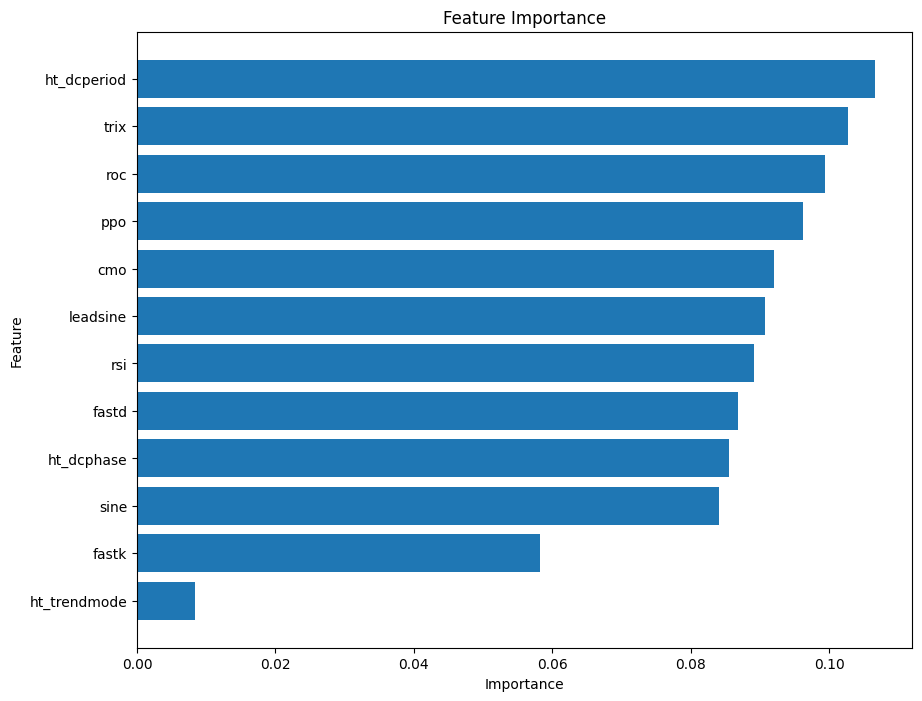

In [58]:
# 변수 중요도 계산
feature_importances = rf.feature_importances_
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [61]:
# 중요도가 0.08 이상인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0.09]['Feature']

# 선택한 변수만을 사용한 새로운 데이터 준비
train_x_rf = train_x[positive_features]
test_x_rf = test_x[positive_features]

# 데이터 스케일링
train_x_rf = scaler.fit_transform(train_x_rf)
test_x_rf = scaler.transform(test_x_rf)

# 모델 선언 및 학습
rf_important_v = RandomForestClassifier(random_state=123)
rf_important_v.fit(train_x_rf, train_y)

train_pred_important_v = rf_important_v.predict(train_x_rf)
y_pred_important_v = rf_important_v.predict(test_x_rf)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

train Accuracy: 1.0000
test Accuracy: 0.5080


In [62]:
# 변수 선택 모델 optuna

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    model = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        random_state=123
    )
    
    scores = cross_val_score(model, train_x_rf, train_y, cv=5, scoring='accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-24 12:12:15,887] A new study created in memory with name: no-name-17f3cdef-63fd-4ad9-a4cf-8dfe7ab24e31
[I 2024-07-24 12:12:21,467] Trial 0 finished with value: 0.4928288854674537 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 16, 'n_estimators': 280}. Best is trial 0 with value: 0.4928288854674537.
[I 2024-07-24 12:12:25,380] Trial 1 finished with value: 0.49514370028226845 and parameters: {'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 15, 'n_estimators': 209}. Best is trial 1 with value: 0.49514370028226845.
[I 2024-07-24 12:12:30,874] Trial 2 finished with value: 0.47064943118638264 and parameters: {'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 1, 'n_estimators': 210}. Best is trial 1 with value: 0.49514370028226845.
[I 2024-07-24 12:12:32,460] Trial 3 finished with value: 0.5127042169189976 and parameters: {'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 6, 'n_estimators': 106}. Best is trial 3 with

Best trial: 0.5293494996150885
Best parameters: {'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 1, 'n_estimators': 52}


In [63]:
best_params = study.best_params
rf_optuna = RandomForestClassifier(**best_params, random_state = 123)
rf_optuna.fit(train_x_rf, train_y)

train_pred_optuna = rf_optuna.predict(train_x_rf)
y_pred_optuna = rf_optuna.predict(test_x_rf)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

train Accuracy: 0.5682
test Accuracy: 0.5561


In [65]:
calcu_df['rf_predict'] = y_pred_optuna
calcu_df['rf_predict'].value_counts()

rf_predict
1    307
0     67
Name: count, dtype: int64

### xgb

In [67]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# XGB 모델 생성
xg = xgb.XGBClassifier(random_state=123)

# 모델 학습
xg.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = xg.predict(train_x_scaled)
y_pred = xg.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.9977
test Accuracy: 0.5321


         Feature  Importance
9          fastk    0.098220
7            roc    0.097869
1    ht_dcperiod    0.094453
11          trix    0.093573
0            cmo    0.093130
10         fastd    0.092835
4       leadsine    0.092664
6            ppo    0.090737
3           sine    0.088458
2     ht_dcphase    0.088246
5   ht_trendmode    0.069815
8            rsi    0.000000


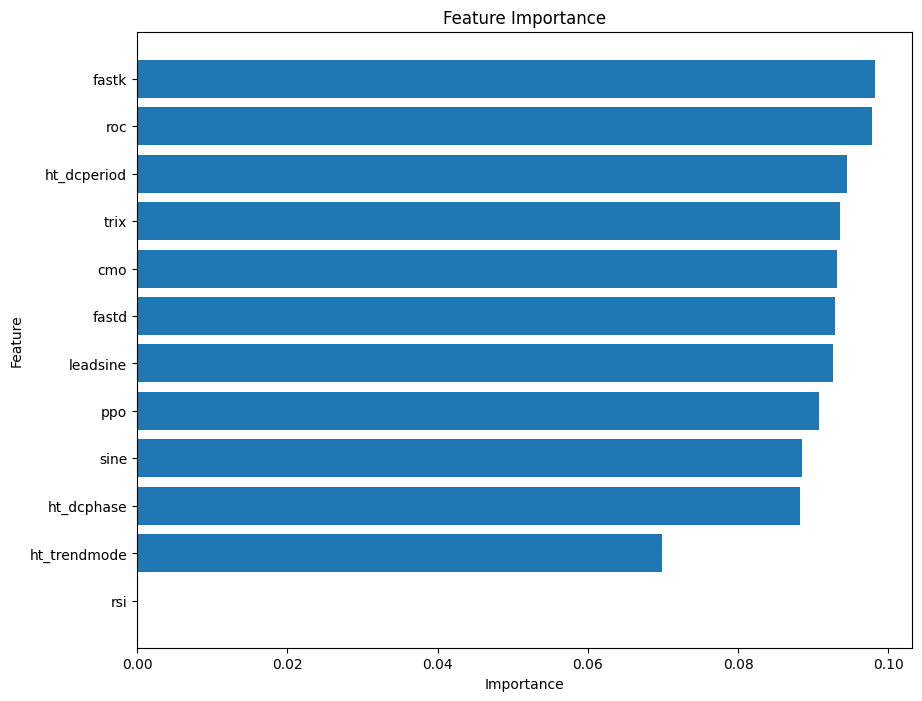

In [68]:
# 변수 중요도 계산
feature_importances = xg.feature_importances_
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [72]:
# 중요도가 0.09 이상인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0.092]['Feature']

# 선택한 변수만을 사용한 새로운 데이터 준비
train_x_xg = train_x[positive_features]
test_x_xg = test_x[positive_features]

# 데이터 스케일링
train_x_xg = scaler.fit_transform(train_x_xg)
test_x_xg = scaler.transform(test_x_xg)

# 모델 선언 및 학습
xg_important_v = xgb.XGBClassifier(random_state=123)
xg_important_v.fit(train_x_xg, train_y)

train_pred_important_v = xg_important_v.predict(train_x_xg)
y_pred_important_v = xg_important_v.predict(test_x_xg)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

train Accuracy: 0.9977
test Accuracy: 0.5668


In [92]:
# 선택 변수 모델로 optuna

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }
    
    model = xgb.XGBClassifier(**param, random_state=123)
    scores = cross_val_score(model, train_x_xg, train_y, cv=5, scoring='accuracy')

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-24 12:22:10,968] A new study created in memory with name: no-name-70244e9f-1d75-4061-b593-e3573cbd850b
[I 2024-07-24 12:22:11,305] Trial 0 finished with value: 0.5224029167735864 and parameters: {'max_depth': 6, 'learning_rate': 0.05303494640511597, 'n_estimators': 345, 'subsample': 0.6188297812682207, 'colsample_bytree': 0.8561703890428743, 'gamma': 4.931773565845469, 'reg_alpha': 4.261213075578634, 'reg_lambda': 0.45910690577712354}. Best is trial 0 with value: 0.5224029167735864.
[I 2024-07-24 12:22:11,686] Trial 1 finished with value: 0.519170729621076 and parameters: {'max_depth': 4, 'learning_rate': 0.006192692888772038, 'n_estimators': 318, 'subsample': 0.751287150709731, 'colsample_bytree': 0.6846367398006126, 'gamma': 3.9484860899684264, 'reg_alpha': 1.3573984621706021, 'reg_lambda': 3.3181473045721956}. Best is trial 0 with value: 0.5224029167735864.
[I 2024-07-24 12:22:11,853] Trial 2 finished with value: 0.5136205200581644 and parameters: {'max_depth': 7, 'learni

Best trial: 0.5224029167735864
Best parameters: {'max_depth': 6, 'learning_rate': 0.05303494640511597, 'n_estimators': 345, 'subsample': 0.6188297812682207, 'colsample_bytree': 0.8561703890428743, 'gamma': 4.931773565845469, 'reg_alpha': 4.261213075578634, 'reg_lambda': 0.45910690577712354}


In [93]:
best_params = study.best_params
xg_optuna = xgb.XGBClassifier(**best_params, random_state=123)
xg_optuna.fit(train_x_xg, train_y)

train_pred_optuna = xg_optuna.predict(train_x_xg)
y_pred_optuna = xg_optuna.predict(test_x_xg)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

train Accuracy: 0.5682
test Accuracy: 0.5695


In [95]:
# 수익률 계산용 데이터프레임에 예측값 추가
calcu_df['xg_predict'] = y_pred_optuna
calcu_df.head(5)
calcu_df['xg_predict'].value_counts()

xg_predict
1    218
0    156
Name: count, dtype: int64

In [96]:
# calcu_df.to_csv("./models_predict_microsoft.csv")

# Back test

In [5]:
calcu_df = pd.read_csv('./models_predict_microsoft.csv', index_col='Date')

In [6]:
bt_df = calcu_df.copy()

bt_df.index = pd.to_datetime(bt_df.index)

bt_df

,Open,Close,label,lr_predict,knn_predict,nb_predict,rf_predict,xg_predict
Date,,,,,,,,
2023-01-03,243.080002,236.609222,0,1,1,1,1,1
2023-01-04,232.279999,226.259155,0,1,1,1,1,1
2023-01-05,227.199997,219.553375,1,1,1,1,1,1
2023-01-06,223.000000,222.140900,1,1,1,1,1,1
2023-01-09,226.449997,224.303711,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
2024-06-24,449.799988,447.670013,1,0,1,1,1,1
2024-06-25,448.250000,450.950012,1,0,0,0,1,0
2024-06-26,449.000000,452.160004,1,0,1,0,1,1


In [7]:
# 초기 자금
initial_capital = 10000.0

# 첫 번째 행의 Open 가격으로 주식 구매
first_open = bt_df.iloc[0]['Close']
shares_bought = initial_capital / first_open

# 포트폴리오 가치 계산
bt_df['Portfolio Value'] = bt_df['Close'] * shares_bought

# 최대 하락폭 (MDD) 계산
bt_df['Cumulative Max'] = bt_df['Portfolio Value'].cummax()
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100

# 최종 포트폴리오 가치
final_close = bt_df.iloc[-1]['Close']
final_portfolio_value = shares_bought * final_close

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Return: {roi:.2f}%")
print(f"MDD: {max_drawdown:.2f}%")

Final Portfolio Value: 18889.796780617457
Return: 88.90%
MDD: -12.99%


# 수수료

In [8]:
# 초기 자금
initial_capital = 10000.0

# 수수료율 설정
commission_rate = 0.0025

# 첫 번째 행의 Close 가격으로 주식 구매
first_open = bt_df.iloc[0]['Close']
shares_bought = initial_capital * (1 - commission_rate) / first_open

# 포트폴리오 가치 계산
bt_df['Portfolio Value'] = bt_df['Close'] * shares_bought * (1 - commission_rate)

# 최대 하락폭 (MDD) 계산
bt_df['Cumulative Max'] = bt_df['Portfolio Value'].cummax()
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100

# 최종 포트폴리오 가치
final_close = bt_df.iloc[-1]['Close']
final_portfolio_value = shares_bought * final_close * (1 - commission_rate)

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Return: {roi:.2f}%")
print(f"MDD: {max_drawdown:.2f}%")


Final Portfolio Value: 18795.465857944248
Return: 87.95%
MDD: -12.99%


# voting 전략

In [9]:
calcu_df['sum'] = calcu_df.iloc[:, 3:8].sum(axis=1)
print(calcu_df['sum'])

Date
2023-01-03    5
2023-01-04    5
2023-01-05    5
2023-01-06    5
2023-01-09    5
             ..
2024-06-24    4
2024-06-25    1
2024-06-26    3
2024-06-27    4
2024-06-28    5
Name: sum, Length: 374, dtype: int64


In [10]:
calcu_df['sum'].value_counts()

sum
5    120
2     82
4     62
1     46
3     44
0     20
Name: count, dtype: int64

In [11]:
# 시그널 생성 홤수 (5일때만 buy)
def generate_sum_signal(row, prev_sum):
    if row['sum'] == 5:
        return 'holding' if prev_sum == 5 else 'buy'
    else:
        return 'clear' if prev_sum == 5 else 'no_action'

Payoff Ratio: 1.437355588368314  
Profit Factor: 3.6587233158466175  
Final Portfolio Value: 13865.245625577369  
Return: 38.65%  
MDD: -7.21%  
Win Rate: 71%  
Number of Trades: 79  

In [111]:
# 시그널 생성 홤수 (4이상일 때 buy)
def generate_sum_signal(row, prev_sum):
    if row['sum'] >= 4:
        return 'holding' if prev_sum >= 4 else 'buy'
    else:
        return 'clear' if prev_sum >= 4 else 'no_action'

Payoff Ratio: 1.421509320469899  
Profit Factor: 3.948637001305275  
Final Portfolio Value: 16001.390599560946  
Return: 60.01%  
MDD: -9.64%  
Win Rate: 72%  
Number of Trades: 69  

In [12]:
# 시그널 생성 홤수 (3이상일 때 buy)
def generate_sum_signal(row, prev_sum):
    if row['sum'] >= 3:
        return 'holding' if prev_sum >= 3 else 'buy'
    else:
        return 'clear' if prev_sum >= 3 else 'no_action'

Payoff Ratio: 1.0656642376619332  
Profit Factor: 6.607118273503986  
Final Portfolio Value: 19557.349668901956  
Return: 95.57%  
MDD: -9.64%  
Win Rate: 85%  
Number of Trades: 73  

In [13]:
# 값 초기화
calcu_df['sum_signal'] = ''
prev_sum = 0

# 시그널 생성 함수 적용
for idx, row in calcu_df.iterrows():
    calcu_df.at[idx, 'sum_signal'] = generate_sum_signal(row, prev_sum)
    prev_sum = int(row['sum'])

calcu_df.head(10)

,Open,Close,label,lr_predict,knn_predict,nb_predict,rf_predict,xg_predict,sum,sum_signal
Date,,,,,,,,,,
2023-01-03,243.080002,236.609222,0,1,1,1,1,1,5,buy
2023-01-04,232.279999,226.259155,0,1,1,1,1,1,5,holding
2023-01-05,227.199997,219.553375,1,1,1,1,1,1,5,holding
2023-01-06,223.000000,222.140900,1,1,1,1,1,1,5,holding
2023-01-09,226.449997,224.303711,1,1,1,1,1,1,5,holding
2023-01-10,227.759995,226.012268,1,1,1,1,1,1,5,holding
2023-01-11,231.289993,232.846481,1,1,1,1,1,1,5,holding
2023-01-12,235.259995,235.552475,1,1,0,1,1,1,4,holding
2023-01-13,237.000000,236.263550,1,1,0,1,1,1,4,holding


In [14]:
bt_df = calcu_df.copy()
bt_df = bt_df[['Open', 'Close', 'sum_signal']]

bt_df.index = pd.to_datetime(bt_df.index)

bt_df

,Open,Close,sum_signal
Date,,,
2023-01-03,243.080002,236.609222,buy
2023-01-04,232.279999,226.259155,holding
2023-01-05,227.199997,219.553375,holding
2023-01-06,223.000000,222.140900,holding
2023-01-09,226.449997,224.303711,holding
...,...,...,...
2024-06-24,449.799988,447.670013,buy
2024-06-25,448.250000,450.950012,clear
2024-06-26,449.000000,452.160004,buy


In [15]:
# 초기 자금
initial_capital = 10000.0
cash = initial_capital
shares = 0
num_trades = 0
wins = 0
profit_sum = 0
loss_sum = 0
win_trades = []
loss_trades = []
 
# 포트폴리오 가치 추적 리스트
portfolio_values = []
cumulative_max = initial_capital  # 누적 최대값 초기화

buy_price = 0

for index, row in bt_df.iterrows():
    signal = row['sum_signal']
    close_price = row['Close']
    
    if signal == 'buy' and cash > 0:
        # 매수: 현재 현금으로 최대한 많은 주식을 구매
        shares += cash / close_price
        cash = 0
        cumulative_max = shares * close_price  # 누적 최대값 초기화
        buy_price = close_price
        num_trades += 1  # 매수 시 거래 횟수 증가
    elif signal == 'clear' and shares > 0:
        # 매도: 현재 보유한 모든 주식을 판매
        cash += shares * close_price
        shares = 0
        cumulative_max = cash  # 누적 최대값 초기화
        num_trades += 1  # 매도 시 거래 횟수 증가
        
        trade_profit = close_price - buy_price
        
        if trade_profit > 0:
            wins += 1
            profit_sum += trade_profit
            win_trades.append(trade_profit)
        else:
            loss_sum += abs(trade_profit)
            loss_trades.append(trade_profit)
    
    # 현재 포트폴리오 가치 계산
    portfolio_value = cash + shares * close_price
    portfolio_values.append(portfolio_value)
    
    # 누적 최대값 갱신
    if portfolio_value > cumulative_max:
        cumulative_max = portfolio_value
    
    bt_df.loc[index, 'Cumulative Max'] = cumulative_max

# 백테스트 결과 DataFrame에 추가
bt_df['Portfolio Value'] = portfolio_values

# 최대 하락폭 (MDD) 계산
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100  # 퍼센트로 변환

# 최종 포트폴리오 가치
final_portfolio_value = portfolio_values[-1]

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# 승률 계산
win_rate = (wins / (num_trades / 2)) * 100  # 매수-매도 한 쌍을 한 거래로 간주하여 승률 계산

# Payoff Ratio 계산
average_profit_per_winning_trade = profit_sum / len(win_trades) if win_trades else 0
average_loss_per_losing_trade = loss_sum / len(loss_trades) if loss_trades else 0
payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')

# Profit Factor 계산
profit_factor = profit_sum / loss_sum if loss_sum != 0 else float('inf')

print(f"Payoff Ratio: {payoff_ratio}  ")
print(f"Profit Factor: {profit_factor}  ")
print(f"Final Portfolio Value: {final_portfolio_value}  ")
print(f"Return: {roi:.2f}%  ")
print(f"MDD: {max_drawdown:.2f}%  ")
print(f"Win Rate: {win_rate:.0f}%  ")
print(f"Number of Trades: {num_trades}  ")

Payoff Ratio: 1.0656642376619332  
Profit Factor: 6.607118273503986  
Final Portfolio Value: 19557.349668901956  
Return: 95.57%  
MDD: -9.64%  
Win Rate: 85%  
Number of Trades: 73  


# 수수료

In [16]:
# 초기 자금
initial_capital = 10000.0
cash = initial_capital
shares = 0
num_trades = 0
wins = 0
profit_sum = 0
loss_sum = 0
win_trades = []
loss_trades = []

# 포트폴리오 가치 추적 리스트
portfolio_values = []
cumulative_max = initial_capital  # 누적 최대값 초기화

buy_price = 0

# 수수료율 설정
commission_rate = 0.0025

for index, row in bt_df.iterrows():
    signal = row['sum_signal']
    close_price = row['Close']
    
    if signal == 'buy' and cash > 0:
        # 매수: 현재 현금으로 최대한 많은 주식을 구매
        total_cost = cash * (1 - commission_rate)  # 수수료 차감
        shares_bought = total_cost / close_price
        cash -= total_cost
        shares += shares_bought
        cumulative_max = shares * close_price  # 누적 최대값 초기화
        buy_price = close_price
        num_trades += 1  # 매수 시 거래 횟수 증가
    elif signal == 'clear' and shares > 0:
        # 매도: 현재 보유한 모든 주식을 판매
        total_sale = shares * close_price * (1 - commission_rate)  # 수수료 차감
        cash += total_sale
        shares = 0
        cumulative_max = cash  # 누적 최대값 초기화
        num_trades += 1  # 매도 시 거래 횟수 증가
        
        trade_profit = (close_price - buy_price) * (1 - commission_rate)
        
        if trade_profit > 0:
            wins += 1
            profit_sum += trade_profit
            win_trades.append(trade_profit)
        else:
            loss_sum += abs(trade_profit)
            loss_trades.append(trade_profit)
    
    # 현재 포트폴리오 가치 계산
    portfolio_value = cash + shares * close_price
    portfolio_values.append(portfolio_value)
    
    # 누적 최대값 갱신
    if portfolio_value > cumulative_max:
        cumulative_max = portfolio_value
    
    bt_df.loc[index, 'Cumulative Max'] = cumulative_max

# 백테스트 결과 DataFrame에 추가
bt_df['Portfolio Value'] = portfolio_values

# 최대 하락폭 (MDD) 계산
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100  # 퍼센트로 변환

# 최종 포트폴리오 가치
final_portfolio_value = portfolio_values[-1]

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# 승률 계산
win_rate = (wins / (num_trades / 2)) * 100  # 매수-매도 한 쌍을 한 거래로 간주하여 승률 계산

# Payoff Ratio 계산
average_profit_per_winning_trade = profit_sum / len(win_trades) if win_trades else 0
average_loss_per_losing_trade = loss_sum / len(loss_trades) if loss_trades else 0
payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')

# Profit Factor 계산
profit_factor = profit_sum / loss_sum if loss_sum != 0 else float('inf')

print(f"Payoff Ratio: {payoff_ratio}  ")
print(f"Profit Factor: {profit_factor}  ")
print(f"Final Portfolio Value: {final_portfolio_value}  ")
print(f"Return: {roi:.2f}%  ")
print(f"MDD: {max_drawdown:.2f}%  ")
print(f"Win Rate: {win_rate:.0f}%  ")
print(f"Number of Trades: {num_trades}  ")

Payoff Ratio: 1.0656642376619334  
Profit Factor: 6.607118273503986  
Final Portfolio Value: 17846.98477934937  
Return: 78.47%  
MDD: -9.61%  
Win Rate: 85%  
Number of Trades: 73  


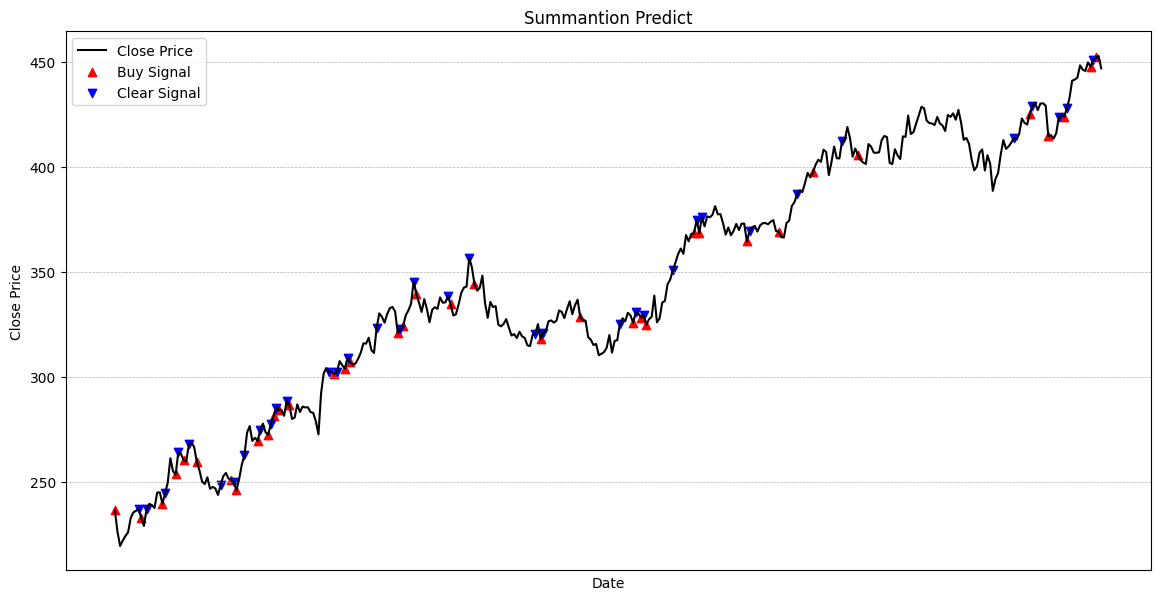

In [119]:
# Close 값 시각화
plt.figure(figsize=(14, 7))
plt.plot(calcu_df.index, calcu_df['Close'], label='Close Price', color='black')

# 'buy' 시그널 빨간색 점으로 표시
buy_signals = calcu_df[calcu_df['sum_signal'] == 'buy']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', color='red', marker='^', alpha=1)

# 'clear' 시그널 파란색 점으로 표시
clear_signals = calcu_df[calcu_df['sum_signal'] == 'clear']
plt.scatter(clear_signals.index, clear_signals['Close'], label='Clear Signal', color='blue', marker='v', alpha=1)

# 그래프 제목과 축 레이블 설정
plt.title('Summantion Predict')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# 그리드 설정 - 세로선 제거
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='x')

# x축 날짜 레이블 비활성화
plt.xticks([])

plt.show()